## Basic Setup

Run the cells below for the basic setup of this notebook.

In [5]:
try:
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False
    print('No colab environment, assuming local setup.')

if IN_COLAB:
    drive.mount('/content/drive')

    # TODO: Enter the foldername in your Drive where you have saved the unzipped
    # turorials folder, e.g. 'alphafold-decoded/tutorials'
    FOLDERNAME = None
    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    import sys
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

    print('Connected COLAB to Google Drive.')

No colab environment, assuming local setup.


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [4]:
from control_values.bunny_renderer import BunnyRenderer
from matplotlib import pyplot as plt
import ipywidgets
import torch
import math
import os

In [3]:
base_folder = 'geometry'
control_folder = f'{base_folder}/control_values'
assert os.path.isdir(control_folder)

In [4]:
torch.set_grad_enabled(False)

# Geometry

Three-dimensional geometry is an undeniably fascinating field, and yes, there's a bit of math involved. Luckily, it's the kind of math that opens up new ways of understanding the world. By the time you finish this notebook, you'll have done more than just implement key AlphaFold methods – you'll have a solid grasp of 3D movement, rotation matrices, quaternions, and homogenous coordinates. 

## Getting Started

Let's take a look at our test object in this notebook.

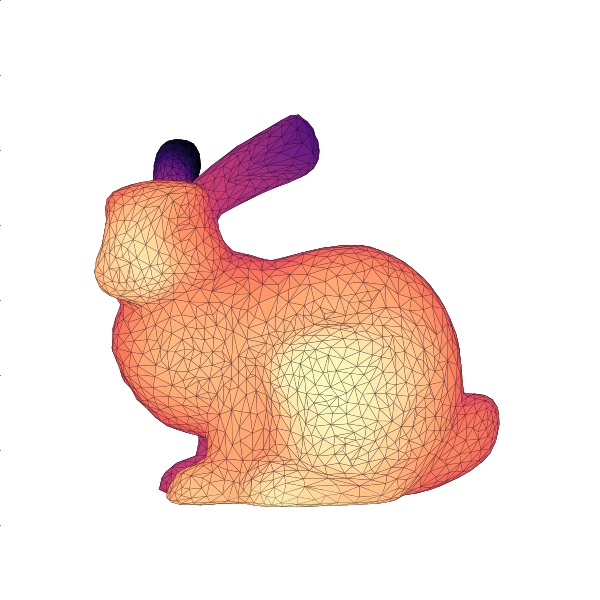

In [6]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1, frameon=False)

renderer = BunnyRenderer()
V = renderer.load_bunny(f'{control_folder}/bunny.obj')
renderer.render_bunny(V, ax)

When loading the bunny, the renderer returns the vertices of the mesh. These can be manipulated before they are passed back to the render method. Try moving the rabbit around by adding an offset like torch.tensor([0.5, 0, 0]) to them. In which directions are the x, y, and z axes of the coordinate frame pointing?

In [7]:
print(V.shape)

torch.Size([2503, 3])


(-1.0, 1.0)

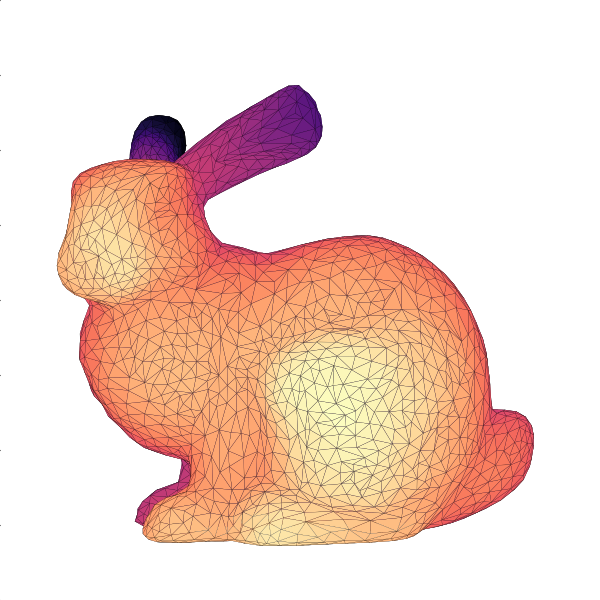

In [8]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1, frameon=False)
ax.clear()

renderer = BunnyRenderer()
V = renderer.load_bunny(f'{control_folder}/bunny.obj')


##########################################################################
# TODO: Move the bunny around by adding an offset to the vertices.       # 
#  In which directions are the x, y, and z axes pointing?                #
##########################################################################

V += torch.tensor([0, 0, 0.5]).float()

##########################################################################
#               END OF YOUR CODE                                         #
##########################################################################

renderer.render_bunny(V, ax)
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))


Point out the thumb, index and middle finger of your right hand, such that they are all orthogonal to each other. You will probably find there is only one way you can do this. Twist your hand so that your thumb is pointing in the direction of the x-axis and your index finger is pointing in the direction of the y-axis. Your middle finger should now align with the z-axis. Theoretically, there are two possible directions for the z-axis (the direction your middle finger is pointing, or the opposite ones) and the vectors would still be orthogonal. But it is convention to choose the axes in the way done here. 

This is actually called a <b>right-handed coordinate system</b>.

Given the first two vectors, the third one is already defined, as you can see from the direction your middle finger is pointing after orienting thumb and index finger to your chosen orientation. As it is fully determined, there is also a mathematical formula to compute it, and it is called the cross-product. The cross-product of two orthogonal vectors is the vector that is orthogonal to both in a right-handed fashion. Its magnitude is the product of the magnitudes of the input vectors, so for unit vectors, it also is a unit vector.

## Rotation Matrices

Moving the bunny around is fun, but for a more serious analysis, we will have to rotate him as well. The most straight-forward method to describe 3D rotations is by rotation matrices. A rotation matrix is just any 3x3 matrix, where the three columns are orthogonal and unit vectors (orthonormal) and oriented in a right-handed fashion. The simplest rotation matrix is just the identity matrix, with 1 on the diagonal and 0s everywhere else. Try coming up with a set of three such vectors and combine them in a matrix, then multiply it against the vertices to rotate the bunny.

(-1.0, 1.0)

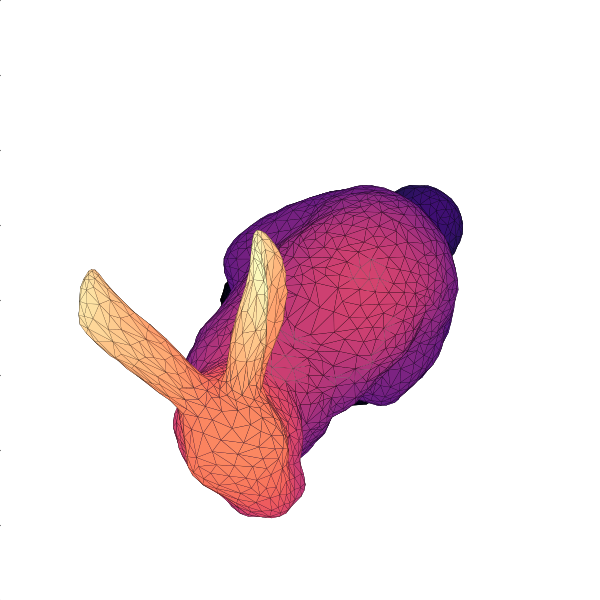

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1, frameon=False)

renderer = BunnyRenderer()
V = renderer.load_bunny(f'{control_folder}/bunny.obj')

rot_mat = None
warped_V = None

##########################################################################
# TODO: Create a rotation matrix by choosing three orthonormal vectors,  # 
#  that follow a right-handed orientation. You can achieve that by       #
#  finding two orthonormal vectors and then compute the third with       #
#  torch.linalg.cross as there cross product. Use torch.stack to stack   #
#  them as columns in a matrix. Then, use batched matrix multiplication  #
#  to multiply the matrix from the left against V to rotate the bunny.   #
#  You can use torch.einsum for this.                                    #
##########################################################################

ex = torch.tensor([1, 1, 0]).float()/ math.sqrt(2)
ey = torch.tensor([0, 0, 1]).float()
ez = torch.linalg.cross(ex, ey)
rot_mat = torch.stack((ex, ey, ez), dim=1)
warped_V = torch.einsum('ij,Nj->Ni', rot_mat, V)

##########################################################################
#               END OF YOUR CODE                                         #
##########################################################################

assert torch.allclose(torch.eye(3), rot_mat@rot_mat.T), 'Columns are not orthonormal.'
assert abs(torch.linalg.det(rot_mat)-1) < 1e-3, 'Columns are not right-handed.'
assert torch.allclose(V, warped_V@rot_mat), 'rot_mat not multiplicated against V correctly.'

renderer.render_bunny(warped_V, ax)
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))

Take a look where the scut of the rabbit is facing. It was previously oriented to (1,0,0), the x-axis. It should now point in the direction you chose as the first column of the rotation matrix. The same holds for the top of the bunny. It was previously looking at (0, 1, 0) and should now be oriented towards the second column. Check this against the rotation matrix you chose.

This is exactly what a rotation matrix does: The columns, the axes of the new frame, define where the former base axes x, y and z are rotated towards, and all other parts follow accordingly.

## Quaternions

tensor(1.0000)
tensor(1.0000)
tensor(1.0000)
tensor(1.0000)


interactive(children=(FloatSlider(value=0.5, description='x', max=1.0), Output()), _dom_classes=('widget-inter…

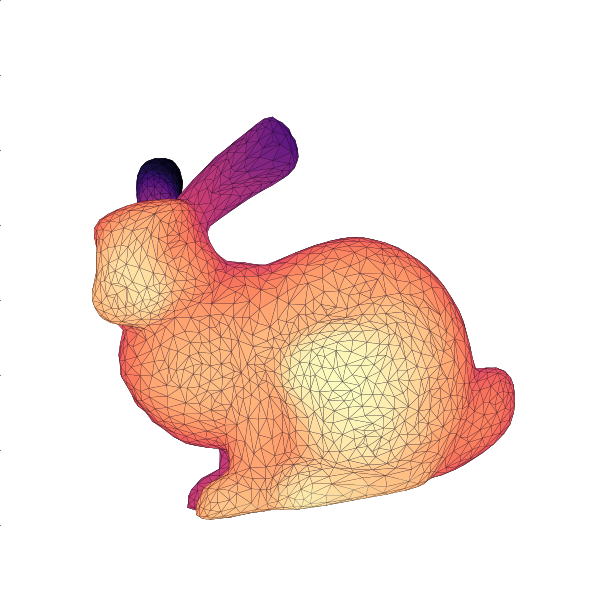

In [13]:
from geometry import create_quaternion, quat_vector_mul, quat_mul

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1, frameon=False)

renderer = BunnyRenderer()
V = renderer.load_bunny(f'{control_folder}/bunny.obj')

q11 = create_quaternion(torch.tensor(math.pi/12), torch.tensor([0.0, 1.0, 0.0]))
q12 = create_quaternion(torch.tensor(math.pi/12), torch.tensor([1.0, 0.0, 0.0]))
quat = quat_mul(q12, q11)

q21 = create_quaternion(torch.tensor(math.pi/12), torch.tensor([0.0, -1.0, 0.0]))
q22 = create_quaternion(torch.tensor(math.pi/12), torch.tensor([-1.0, 0.0, 0.0]))
q2 = quat_mul(q22, q21)

@ipywidgets.interact(x=(0.0, 1.0, 0.1))
def parametric_render(x):
    q = (1-x)*quat+x*q2
    q = q / torch.linalg.vector_norm(q, keepdim=True)
    V_warped = quat_vector_mul(q, V)
    # renderer.reset()
    renderer.render_bunny(V_warped, ax)
    ax.set_xlim((-1, 1))
    ax.set_ylim((-1, 1))

In [16]:

q11 = create_quaternion(torch.tensor(math.pi/12), torch.tensor([0.0, 1.0, 0.0]))
q12 = create_quaternion(torch.tensor(math.pi/12), torch.tensor([1.0, 0.0, 0.0]))
quat = quat_mul(q12, q11)

a, b, c, d = torch.unbind(quat, dim=-1)
R = [
    [a**2+b**2-c**2-d**2, 2*b*c-2*a*d, 2*b*d+2*a*c],
    [2*b*c+2*a*d, a**2-b**2+c**2-d**2, 2*c*d-2*a*b],
    [2*b*d-2*a*c, 2*c*d+2*a*b, a**2-b**2-c**2+d**2]
]
R = [torch.stack(vals, dim=-1) for vals in R]
R = torch.stack(R, dim=-2)
print(R)
R_oth = quat_vector_mul(quat, torch.eye(3))
print(R_oth)

tensor(1.0000)
tensor(1.0000)
tensor([[ 8.6603e-01,  7.4506e-09,  5.0000e-01],
        [ 2.5000e-01,  8.6603e-01, -4.3301e-01],
        [-4.3301e-01,  5.0000e-01,  7.5000e-01]])
tensor([[ 8.6603e-01,  2.5000e-01, -4.3301e-01],
        [ 7.4506e-09,  8.6603e-01,  5.0000e-01],
        [ 5.0000e-01, -4.3301e-01,  7.5000e-01]])


## Homogenous Coordinates

Homogenous coordinates follow a simple idea: Say you have a rotation matrix $R$ and a translation vector $t$. To warp a vector $x$, we can just compute $y = R\cdot x + t$. This seems simple enough, but consider the following 4x4 matrix and vector:

$$ T = \left(\begin{array}{c|c} R & t \\\hline 0\;0\;0 & 1\end{array}\right), \; \tilde{x} = \begin{pmatrix}x\\\hline 1 \end{pmatrix}$$

You can check that the following holds:
$$\tilde{y} = T \cdot \tilde{x}, \; \text{ where } \tilde{y} = \begin{pmatrix}y \\\hline 1\end{pmatrix}$$

This way, just by assembling R and t together in a matrix and padding with (0,0,0,1), we could compute the affine linear transformation $y = R\cdot x + t$ with just a linear matrix multiplication. It is a simple trick that is often used to describe motions (rotations and translations) jointly.